# Autodiff

## Regression in PyTorch

In [2]:
import torch 
import matplotlib.pyplot as plt

In [3]:
x = torch.tensor([0,1,2,3,4,5,6,7.])
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

> 🪶 The `.` at the end of the array of numbers signifies that all these numbers are floating point numbers. This is because PyTorch makes it so that if one of the elements is 0 then all the elements are 0

Now, let's simulatea normally distributed dataset with added noise using `torch.normal()` for our y values

In [4]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=1)
y

tensor([ 2.1873,  3.2151,  2.2642,  1.7364, -0.5472, -0.3032, -0.8469, -0.6753])

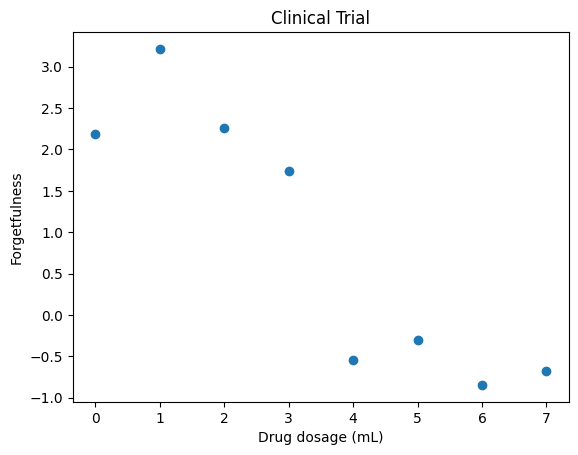

In [5]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x,y)

**Deliberately** choosing a **slope and a y-intercept** that the model will have to work with and tracking gradients through forward pass with `requires_grad()`

In [6]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

m,b

(tensor([0.9000], requires_grad=True), tensor([0.1000], requires_grad=True))

In [7]:
def regression(my_x, my_m, my_b):
    """
    Gives y given x, slope and y-intercept
    """
    return my_m*my_x + my_b

def regression_plot(my_x, my_y, my_m, my_b):
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()
    
    ax.set_xlim([x_min, x_max])
    
    plotx = [x_min, x_max]
    ploty = [y_min, y_max]
    _ = ax.plot(plotx,ploty)

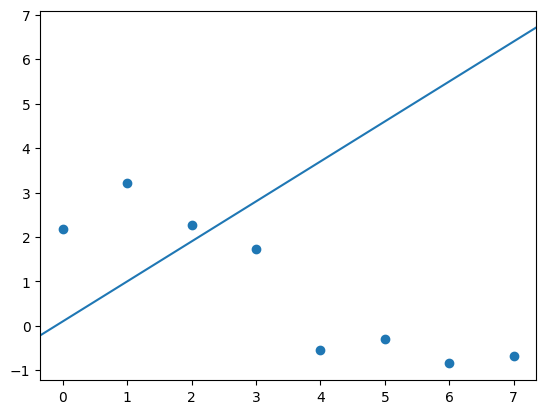

In [8]:
regression_plot(x,y,m,b)
# Plotting our terrible initial points of slope 9 and y-intercept 0.1

## What is a gradient

A gradient is a vector consisting of the partial derivatives of a function with respect to each variable. It points in the direction of the steepest ascent of the function’s value.

### Significance of gradient value:
**Direction**: The way in which you should change your parameters to increase the function’s value the most.

**Magnitude**: How steep the function is at that point; a larger magnitude means a steeper slope.

## Chain Rule's importance

> 🪶 feedforward is the combination of linear transformation and the activation function 
> 
> **Feedforward** $y=\phi(z = weights*inputs + bias)$
> 
> **Slope intercept form** $y = mx + b$

0. Identify the DAG, our parameters here are m and b. Input of x
1. We have the feedforward function in the form of $y = mx+b$
2. Compare $\hat{y}$(yPred) with $y$ (yTrue) to calculate cost $C$
$$\hat{y} = f(x,m,b)$$
$$C = g(\hat{y},y)$$
---
$$C = g(f(x,m,b),y)$$
3. Chain rule to calculate gradient of C with respect to parameters
4. Adjust m and b to reduce $C$

### Step 1: Forward Pass

In [9]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

### Step 2: Getting our Loss/Cost

Using MSE again
$$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

> ❗ Every Output from the functions below are still inputed, displayed and passed as *tensor objects*

In [10]:
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)


In [11]:
C = mse(yhat,y)
C

tensor(17.8688, grad_fn=<DivBackward0>)

### Step 3: Autodiff to calculate gradient of C w.r.t. parameters

Substep 1: Using `.backward()` to calculate the partial derivatives with respect to each parameter in the model. It stores each gradient

In [12]:
C.backward()
C

tensor(17.8688, grad_fn=<DivBackward0>)

In [13]:
#gradient descent of slope and y-intercept
m.grad, b.grad

(tensor([32.3401]), tensor([4.7424]))

### Step 4: Gradient Descent

In [14]:
# initializing our optimizer, now that we have gradient values for m, and b, it's time to do optimization via gradient descent.
optimizer = torch.optim.SGD([m,b], lr=0.01)

In [15]:
# with a learning rate of 0.01, we just adjusted the values of m and b
optimizer.step()
m,b

(tensor([0.5766], requires_grad=True), tensor([0.0526], requires_grad=True))

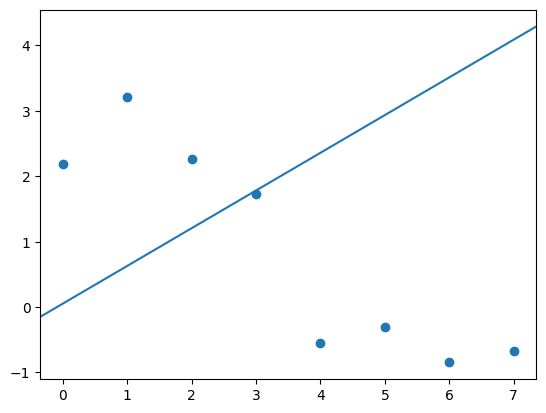

In [16]:
regression_plot(x,y,m,b) #new plot with new values of m and b

Compared to the last plot, our line was much steaper and we reduced the max y of our line from sub 6 to sub 4

Now we repeat steps 1 and 2 to confirm if the cost has decreased:

In [17]:

yhat = regression(x, m, b)
C = mse(yhat,y)
C

tensor(9.1249, grad_fn=<DivBackward0>)

In [18]:
epochs = 1000
# 1000 rounds of training
for epoch in range(epochs):
    optimizer.zero_grad() #resets the gradients to 0 so they don't accumulate
    
    yhat = regression(x, m, b) #step 1
    C = mse(yhat,y) #step 2
    
    C.backward()# steps 3 
    optimizer.step()# step 4
    
    print(f"Epoch {epoch}, cost {C.item():.3g}, m grad {m.grad.item():.3g}, b grad {b.grad.item():.3g}")

Epoch 0, cost 9.12, m grad20.7, b grad2.38
Epoch 1, cost 5.57, m grad13.3, b grad0.888
Epoch 2, cost 4.12, m grad8.57, b grad-0.0596
Epoch 3, cost 3.51, m grad5.58, b grad-0.658
Epoch 4, cost 3.25, m grad3.67, b grad-1.04
Epoch 5, cost 3.12, m grad2.46, b grad-1.27
Epoch 6, cost 3.06, m grad1.69, b grad-1.42
Epoch 7, cost 3.01, m grad1.2, b grad-1.51
Epoch 8, cost 2.97, m grad0.883, b grad-1.56
Epoch 9, cost 2.94, m grad0.683, b grad-1.59
Epoch 10, cost 2.91, m grad0.555, b grad-1.61
Epoch 11, cost 2.88, m grad0.474, b grad-1.61
Epoch 12, cost 2.86, m grad0.421, b grad-1.62
Epoch 13, cost 2.83, m grad0.387, b grad-1.61
Epoch 14, cost 2.8, m grad0.364, b grad-1.61
Epoch 15, cost 2.77, m grad0.349, b grad-1.6
Epoch 16, cost 2.75, m grad0.339, b grad-1.59
Epoch 17, cost 2.72, m grad0.332, b grad-1.59
Epoch 18, cost 2.69, m grad0.327, b grad-1.58
Epoch 19, cost 2.67, m grad0.323, b grad-1.57
Epoch 20, cost 2.64, m grad0.32, b grad-1.56
Epoch 21, cost 2.62, m grad0.317, b grad-1.55
Epoch 22

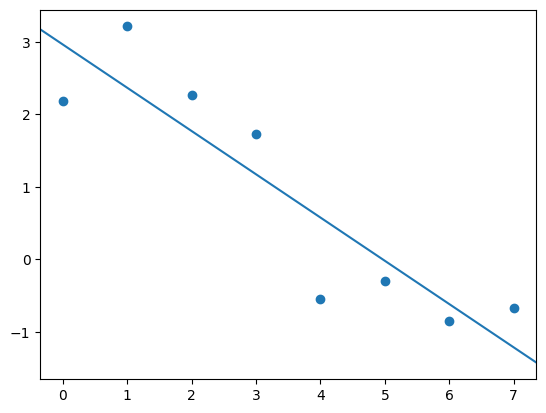

In [19]:
regression_plot(x,y,m,b)

# Challenge
Finding slope of $y = x^2 + 2x + 2$ where $x=2$

In [25]:
def challengeFunc(my_x):
    return my_x**2 + 2*my_x+ 2

In [52]:
x = torch.arange(16, dtype=torch.float32)
#  using 16 data points to get a more accurate result
y = challengeFunc(x)
y

tensor([  2.,   5.,  10.,  17.,  26.,  37.,  50.,  65.,  82., 101., 122., 145.,
        170., 197., 226., 257.])

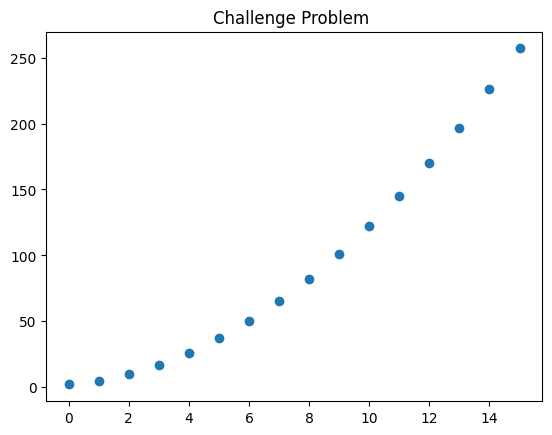

In [53]:
fig, ax = plt.subplots()
plt.title("Challenge Problem ")
_ = ax.scatter(x,y)

In [54]:
m = torch.tensor([5.0]).requires_grad_()
b = torch.tensor([10.0]).requires_grad_()
m,b

(tensor([5.], requires_grad=True), tensor([10.], requires_grad=True))

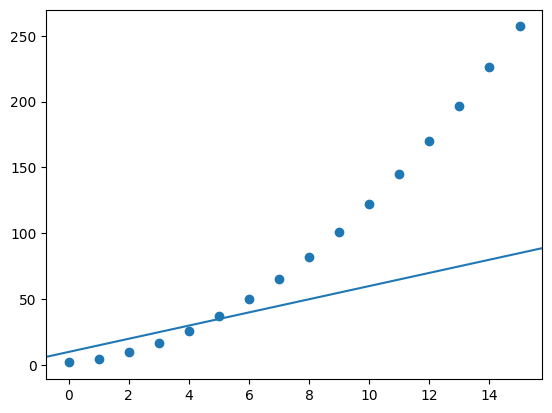

In [55]:
regression_plot(x,y,m,b)

In [60]:
yhat = regression(2.0,m,b)
yhat

tensor([20.], grad_fn=<AddBackward0>)

In [61]:
C = mse(yhat,y)
C

tensor(12048.5000, grad_fn=<DivBackward0>)

In [62]:
# ADjusting the cost function so that thetangent of x=2 is prioritized
def getTangent(my_yhat, my_y):
    sigma = torch.sum((my_yhat-my_y)**2)
    return sigma / len(my_y)
